<a href="https://colab.research.google.com/github/Ravisankar-S/Day10_Team_Task/blob/main/day10_Tasks_Team2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip -q Dataset.zip -d dataset

In [2]:
import shutil
import os

inner_folder = "/content/dataset/Dataset"
outer_folder = "/content/dataset"

for item in os.listdir(inner_folder):
    shutil.move(os.path.join(inner_folder, item), outer_folder)

os.rmdir(inner_folder)

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)
batch_size = 32
data_dir = '/content/dataset'

datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 973 images belonging to 3 classes.
Found 241 images belonging to 3 classes.


In [4]:
import os
for folder in os.listdir('/content/dataset'):
    print(folder, "->", len(os.listdir(os.path.join('/content/dataset', folder))), "images")

ripe -> 579 images
turning -> 142 images
unripe -> 493 images


In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-80]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
outputs = Dense(3, activation='softmax', kernel_regularizer=l2(0.001))(x)  # Changed to 3 classes

model = Model(inputs=base_model.input, outputs=outputs)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, validation_data=val_generator, epochs=25)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.3980 - loss: 1.4066 - val_accuracy: 0.4855 - val_loss: 1.2361
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.7362 - loss: 0.9386 - val_accuracy: 0.6390 - val_loss: 1.0362
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - accuracy: 0.8801 - loss: 0.6734 - val_accuracy: 0.6929 - val_loss: 0.9897
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.9036 - loss: 0.5857 - val_accuracy: 0.6929 - val_loss: 1.0606
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.9123 - loss: 0.5410 - val_accuracy: 0.7095 - val_loss: 0.9543
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.9199 - loss: 0.5052 - val_accuracy: 0.7137 - val_loss: 0.9708
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - accuracy: 0.9441 - loss: 0.4391 - val_accuracy: 0.7178 - val_loss: 0.9429
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.9525 - loss: 0.4236 - val_accuracy: 0.7303 - v

In [7]:
model.save('/content/mobilenetv2_strawberry_ripeness.h5')

In [17]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

model = load_model('/content/mobilenetv2_strawberry_ripeness.h5')

img_path = 'fresa_016_jpg.rf.35d983654531c2fdffa1e505ec609fea.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])

class_names = ['Ripe', 'Unripe', 'Turning']
print("Predicted class:", class_names[predicted_class_index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: Ripe


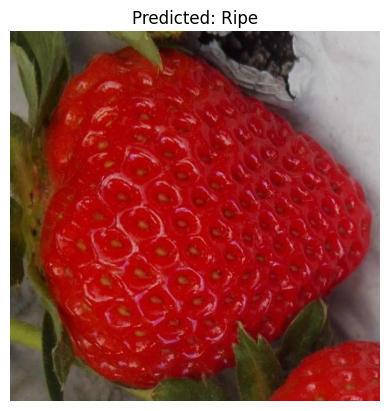

In [18]:
import matplotlib.pyplot as plt

plt.imshow(image.load_img(img_path))
plt.axis('off')
plt.title(f"Predicted: {class_names[predicted_class_index]}")
plt.show()